# Evaluate performance of LSTM (Model 1) on Shasta Reservoir

In this notebook, we analyze the performance of LSTM Model 1 using data from Shasta reservoir. Recall that LSTM Model 1 takes in inflow and the day of the year (DOY) as input, and outputs the predicted release. This notebook is organized in serveral sections:

1. Data processing: manipulate data to use with the models
2. Analyze optimal hyperparameters, using results from grid search conducted in 1(a/b/c)_model1_tuning.py
3. Plot performance on train, val, test sets. Get R2 measure.

We also look at each of the variants of Model 1:
1. Model 1a: standardization, MSE Loss
2. Model 1b: normalization, MSE Loss
3. Model 2c: normalization, RMSLE Loss

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized Data

In [5]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_std, dataset_val_std = (TensorDataset(X_train_std, y_train_std), TensorDataset(X_val_std, y_val_std))
# shuffle = False to preserve time order
dataloader_train_std, dataloader_val_std = (DataLoader(dataset_train_std, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_std, batch_size=1, shuffle=False))

### Normalized Data

In [6]:
# Run data processing pipeline
pipeline_nm = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1, transform_type='normalize', fill_na_method='mean')
# Train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_nm, ts_val_nm, ts_test_nm = pipeline_nm.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_nm, X_val_nm, X_test_nm = ts_train_nm[:, :, [0, 3]], ts_val_nm[:, :, [0, 3]], ts_test_nm[:, :, [0, 3]]
# select outflow as target feature
y_train_nm, y_val_nm, y_test_nm = ts_train_nm[:, :, [1]], ts_val_nm[:, :, [1]], ts_test_nm[:, :, [1]]

# Create PyTorch dataset and dataloader
dataset_train_nm, dataset_val_nm = (TensorDataset(X_train_nm, y_train_nm), TensorDataset(X_val_nm, y_val_nm))
# shuffle = False to preserve time order
dataloader_train_nm, dataloader_val_nm = (DataLoader(dataset_train_nm, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val_nm, batch_size=1, shuffle=False))

In [42]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

## Analyze Model 1a
Model 1(a) uses standardized inflow and DOY as input, and trains on MSE loss.

In [7]:
from src.models.model_zoo import *
from src.models.train_model import *

### Analyze Optimal Hyperparameters for Model 1a
Previously, we conducted a grid search over a predefined parameter space: \
Number LSTM layers; 1, 2\
Hidden size (LSTM): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Hidden size (FF): 5, 10, 15, 20, 25, 30, 35, 40, 45, 50\
Dropout probability: 0.3, 0.5, 0.7

On 5 random seeds: 0, 10, 100, 1000, 10000 which we want to average performance over.

In [8]:
# load in results from grid search
grid_df_1a = pd.read_csv('report/results/hyperparameter_tuning/model1a_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1a['param_id'] = np.repeat(np.arange(int(len(grid_df_1a) / num_random_seeds)), num_random_seeds)
grid_df_mean_1a = grid_df_1a.groupby('param_id').mean()
grid_df_mean_1a.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1a.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1a.to_csv('report/results/hyperparameter_tuning/model1a_avg_tuning.csv')
grid_df_mean_1a[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
306,1.0,30.0,15.0,0.3,74.2,0.363413
324,1.0,30.0,45.0,0.3,60.8,0.368881
138,1.0,15.0,35.0,0.3,107.2,0.372677
441,1.0,40.0,40.0,0.3,68.2,0.374502
555,1.0,50.0,30.0,0.3,64.0,0.375822
319,1.0,30.0,35.0,0.5,89.8,0.377301
307,1.0,30.0,15.0,0.5,95.2,0.378819
315,1.0,30.0,30.0,0.3,62.2,0.378953
564,1.0,50.0,45.0,0.3,63.4,0.379373


In [9]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model1a = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1a.parameters(), lr=0.001)

# load saved model
model1a.load_state_dict(torch.load('src/models/saved_models/model1a.pt'))

# turn model into evaluation model
model1a.eval()

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 30)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

### Evaluate Model 1a goodnes-of-fit

In [11]:
from src.models.predict_model import *
from sklearn.metrics import r2_score

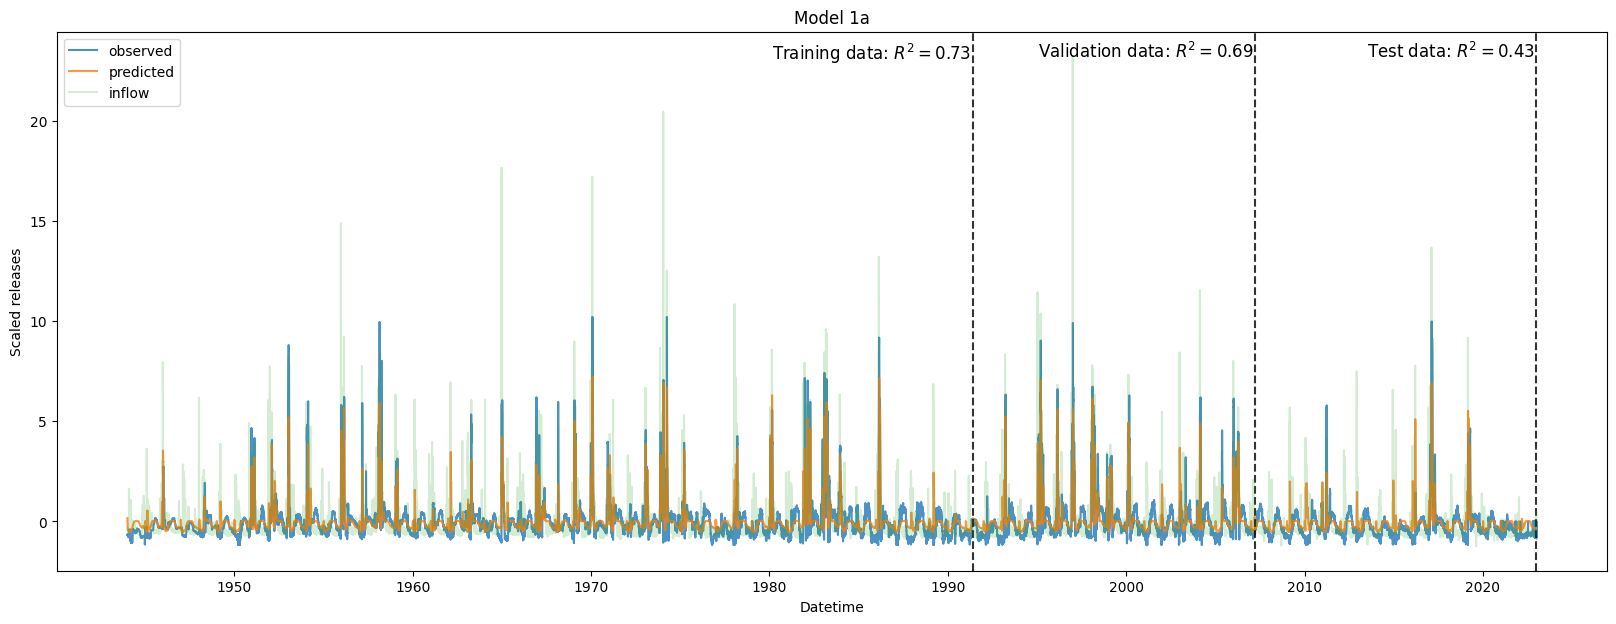

In [38]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_1a, r2_val_1a, r2_test_1a = plot_and_eval(model1a, X_train_std, X_val_std, X_test_std, y_train_std, y_val_std, y_test_std, datetime_index=df.index, ax=ax, text_ypos=24, alpha=0.8)
ax.plot((df.inflow-df.inflow.mean()) / df.inflow.std(), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 1a')
plt.show()

## Analyze Model 1(b)
Model 1(b) takes normalized inflow and DOY as input, and trains on MSE loss

### Analyze hyperparameters for Model 1b

In [20]:
# load in results from grid search
grid_df_1b = pd.read_csv('report/results/hyperparameter_tuning/model1b_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1b['param_id'] = np.repeat(np.arange(int(len(grid_df_1b) / num_random_seeds)), num_random_seeds)
grid_df_mean_1b = grid_df_1b.groupby('param_id').mean()
grid_df_mean_1b.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1b.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1b.to_csv('report/results/hyperparameter_tuning/model1b_avg_tuning.csv')

grid_df_mean_1b[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
528,2.0,45.0,35.0,0.3,104.2,0.003237
327,1.0,30.0,50.0,0.3,117.8,0.003252
561,1.0,50.0,40.0,0.3,131.0,0.003252
324,1.0,30.0,45.0,0.3,122.8,0.003256
384,1.0,35.0,45.0,0.3,106.4,0.003279
591,2.0,50.0,40.0,0.3,93.8,0.003290
564,1.0,50.0,45.0,0.3,112.8,0.003316
444,1.0,40.0,45.0,0.3,97.0,0.003330
447,1.0,40.0,50.0,0.3,95.8,0.003332


### Evaluating Model 1b goodness of fit

In [21]:
# instantiate optimal model
input_size = 2
hidden_size1 = 45
hidden_size2 = 35
output_size = 1
dropout_prob = 0.3
num_layers = 2

torch.manual_seed(0)
model1b = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=2, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1b.parameters(), lr=0.001)

# load saved model
model1b.load_state_dict(torch.load('src/models/saved_models/model1b.pt'))
# turn model into evaluation model
model1b.eval()

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 45)
    (1): LSTMCell(45, 45)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=45, out_features=35, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=35, out_features=1, bias=True)
)

In [22]:
count_parameters(model1b)

27026

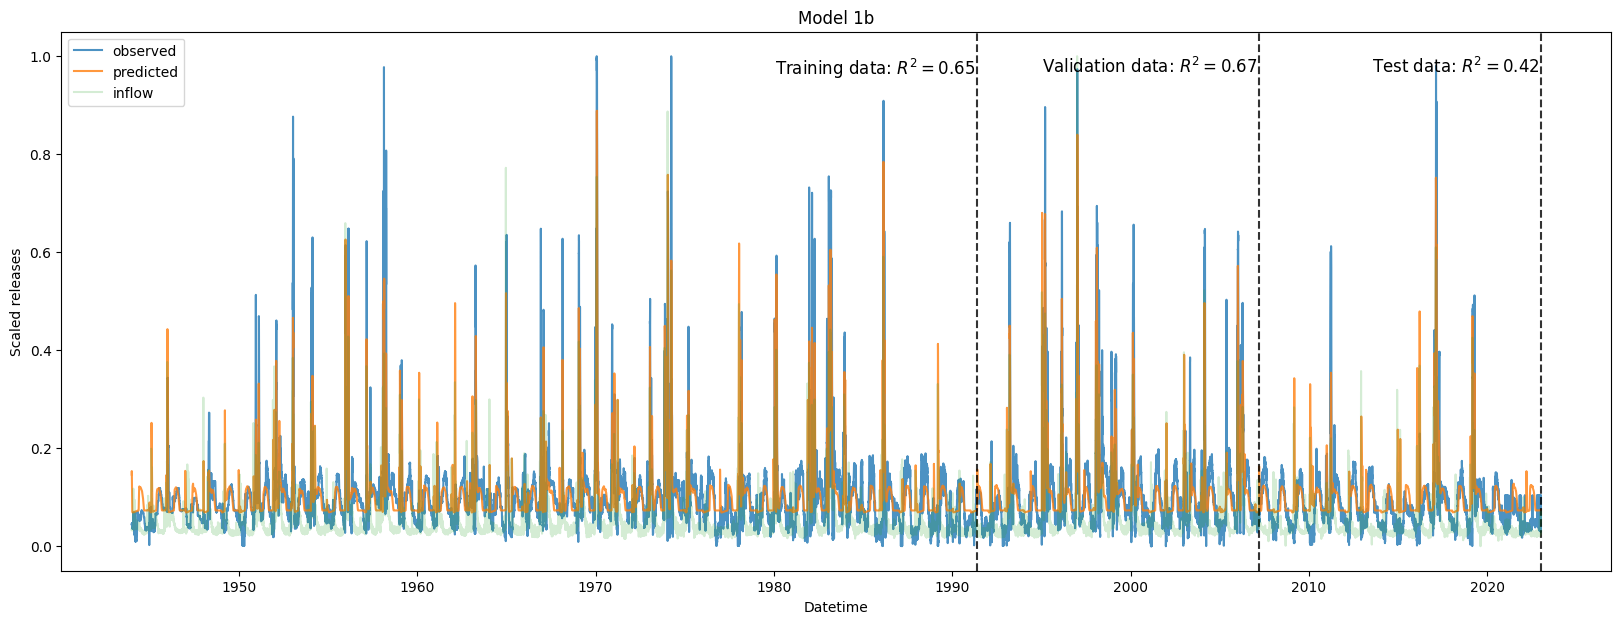

In [37]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_1b, r2_val_1b, r2_test_1b = plot_and_eval(model1b, X_train_nm, X_val_nm, X_test_nm, y_train_nm, y_val_nm, y_test_nm, datetime_index=df.index, ax=ax, text_ypos=1, alpha=0.8)
ax.plot((df.inflow-df.inflow.min()) / (df.inflow.max() - df.inflow.min()), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 1b')
plt.show()

## Analyze Model 1(c)
Model 1(c) takes normalized inflow and DOY as input, and trains on RMSLE loss

### Analyze Hyperparameters for Model 1c

In [31]:
# load in results from grid search
grid_df_1c = pd.read_csv('report/results/hyperparameter_tuning/model1c_tuning.csv', index_col=0)

# average performance over the random seeds
num_random_seeds = 5
grid_df_1c['param_id'] = np.repeat(np.arange(int(len(grid_df_1c) / num_random_seeds)), num_random_seeds)
grid_df_mean_1c = grid_df_1c.groupby('param_id').mean()
grid_df_mean_1c.drop(columns=['random_seed'], inplace=True)

# save sorted df
grid_df_mean_1c.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean_1c.to_csv('report/results/hyperparameter_tuning/model1c_avg_tuning.csv')

grid_df_mean_1c[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
282,2.0,25.0,25.0,0.3,137.0,0.042399
591,2.0,50.0,40.0,0.3,95.4,0.042668
387,1.0,35.0,50.0,0.3,114.6,0.042759
462,2.0,40.0,25.0,0.3,124.8,0.042930
528,2.0,45.0,35.0,0.3,119.4,0.042959
564,1.0,50.0,45.0,0.3,99.6,0.043339
597,2.0,50.0,50.0,0.3,107.8,0.043500
372,1.0,35.0,25.0,0.3,122.8,0.043516
441,1.0,40.0,40.0,0.3,121.2,0.043565


### Evaluate Model 1c goodness-of-fit

In [33]:
# instantiate optimal model
input_size = 2
hidden_size1 = 25
hidden_size2 = 25
output_size = 1
dropout_prob = 0.3
num_layers = 2

torch.manual_seed(0)
model1c = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1c.parameters(), lr=0.001)

# load saved model
model1c.load_state_dict(torch.load('src/models/saved_models/model1c.pt'))
# turn model into evaluation model
model1c.eval()

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 25)
    (1): LSTMCell(25, 25)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=25, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)

In [34]:
count_parameters(model1c)

8776

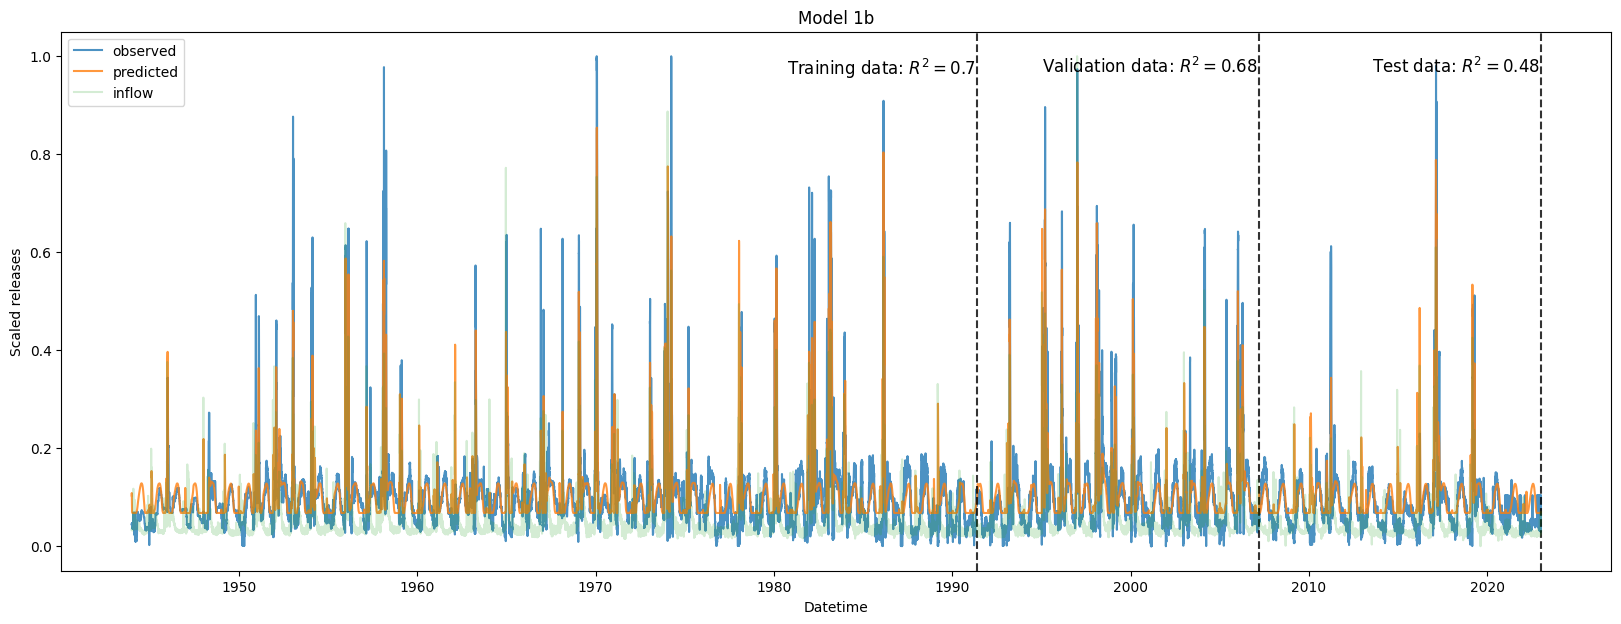

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_1c, r2_val_1c, r2_test_1c = plot_and_eval(model1c, X_train_nm, X_val_nm, X_test_nm, y_train_nm, y_val_nm, y_test_nm, datetime_index=df.index, ax=ax, text_ypos=1, alpha=0.8)
ax.plot((df.inflow-df.inflow.min()) / (df.inflow.max() - df.inflow.min()), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 1b')
plt.show()

## Review Performance

In [41]:
performance = {'training r2': [r2_train_1a, r2_train_1b, r2_train_1c],
               'validation r2' : [r2_val_1a, r2_val_1b, r2_val_1c], 
               'testing r2': [r2_test_1a, r2_test_1b, r2_test_1c]}
perf_df = pd.DataFrame(performance, index=['Model 1a', 'Model 1b', 'Model 1c'])
perf_df

,training r2,validation r2,testing r2
Model 1a,0.731440,0.686186,0.433458
Model 1b,0.645525,0.665200,0.421320
Model 1c,0.695076,0.681365,0.483294
